# BLG556E - Digital Solution for Smart Cities

Halit Uyanık - 504202506<br>
Kadir Şinas Kaynak - 504191525


In [74]:
import os
import sys
import urllib.request
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from utilities.PreProcessingUtil import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [75]:
#read pollutant values
# A N by T feature matrix, which describes the (f_1, .., f_T) speed records over T timesteps for the N sensors.
dfPollutant = pd.read_excel(
     "datasets/pollutants/aksaray.xlsx",
     engine='openpyxl',
     parse_dates=True,
     thousands='.'
)



In [76]:
#remove index column
dfPollutant = dfPollutant.iloc[: , 1:] 

#dataset info
time_len, num_pol = dfPollutant.shape
print("No. of pollution:", num_pol-1, "\nNo of timesteps:", time_len)

No. of pollution: 6 
No of timesteps: 81695


In [77]:
dfPollutant = dfPollutant.iloc[-20000:,:]

In [78]:
dfPollutant

,PM10 ( µg/m3 ),SO2 ( µg/m3 ),CO ( µg/m3 ),NO2 ( µg/m3 ),NOX ( µg/m3 ),O3 ( µg/m3 ),PM 2.5 ( µg/m3 )
61695,"42,20","9,80","407,30","65,30","179,80","19,70","19,10"
61696,"41,80","10,00","555,50","55,50","131,20","20,40","21,60"
61697,"44,20","11,00","570,00","75,50","180,00","16,00","26,40"
61698,"41,70","12,10","620,20","83,00","183,00","11,60","26,20"
61699,"49,70","15,20","648,30","98,50","214,60","13,50","27,10"
...,...,...,...,...,...,...,...
81690,"23,60","3,70","530,00","300,40",-,"3,80",-
81691,"25,90","4,00","606,30","322,50",-,"3,20",-
81692,"27,60","3,60","647,30","318,50",-,"2,90",-
81693,"19,70","3,40","716,70","317,70",-,"2,70",-


In [79]:
dfPollutant = preprocessing(dfPollutant)
dfPollutant = dfPollutant['PM10 ( µg/m3 )']

/Users/deneme/Documents/ders/smart city/project/air-quality-prediction/utilities/PreProcessingUtil.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['PM10 ( µg/m3 )'] = df['PM10 ( µg/m3 )'].astype(str).str.replace('.','')
/Users/deneme/Documents/ders/smart city/project/air-quality-prediction/utilities/PreProcessingUtil.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['SO2 ( µg/m3 )'] = df['SO2 ( µg/m3 )'].astype(str).str.replace('.','')
/Users/deneme/Documents/ders/smart city/project/air-quality-prediction/utilities/PreProcessingUtil.py:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character re

In [80]:
# Train - Test split
def train_test_split(data, train_portion):
    time_len = data.shape[0]
    train_size = int(time_len * train_portion)
    print(train_size)
    train_data = np.array(data.iloc[:train_size])
    test_data = np.array(data.iloc[train_size:])
    return train_data, test_data

# Scaling
def scale_data(train_data, test_data):
    max_speed = train_data.max()
    min_speed = train_data.min()
    train_scaled = (train_data - min_speed) / (max_speed - min_speed)
    test_scaled = (test_data - min_speed) / (max_speed - min_speed)
    return train_scaled, test_scaled

In [81]:
train_rate = 0.8
train_data, test_data = train_test_split(dfPollutant, train_rate)
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)
train_scaled, test_scaled = scale_data(train_data, test_data)

16000
Train data:  (16000,)
Test data:  (4000,)


In [82]:
# This value represents the past feature window size
seq_len = 24
# This value represents how far ahead we want to predict
pre_len = 1
# Data for LSTM is prepared using the Sliding Window approach
# Sliding windows are applied for each sensor
def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data.shape[0] - int(seq_len + pre_len - 1)):
        a = train_data[i : i + seq_len + pre_len]
        trainX.append(a[:seq_len])
        trainY.append(a[-1])

    for i in range(test_data.shape[0] - int(seq_len + pre_len - 1)):
        b = test_data[i : i + seq_len + pre_len]
        testX.append(b[:seq_len])
        testY.append(b[-1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [83]:
# We expect to see features of seq_len window size for each sensor 
# and labels as the pre_len ahead output
trainX, trainY, testX, testY = sequence_data_preparation(
    seq_len, pre_len, train_scaled, test_scaled
)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(15976, 24)
(15976,)
(3976, 24)
(3976,)


In [84]:
subsequences = 2
timesteps = trainX.shape[1]//subsequences
X_train_series_sub = trainX.reshape((trainX.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = testX.reshape((testX.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (15976, 2, 12, 1)
Validation set shape (3976, 2, 12, 1)


In [85]:
lstm_layer_sizes = 50
lstm_activations = "relu"
cnn_activations = "relu"
loss='mae'
optimizer='adam'
n_epochs=50
batch_size=72
shuffle=False
verbose=2
# design network
model_cnn_lstm = Sequential()
model_cnn_lstm.add(
    TimeDistributed(Conv1D(filters=64, kernel_size=1, activation=cnn_activations), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3]))
    )
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(lstm_layer_sizes, activation=lstm_activations))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss=loss, optimizer=optimizer)
# fit network
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, trainY, validation_data=(X_valid_series_sub, testY), epochs=n_epochs, verbose=verbose)

Train on 15976 samples, validate on 3976 samples
Epoch 1/50
 - 17s - loss: 0.0241 - val_loss: 0.0177
Epoch 2/50
 - 10s - loss: 0.0155 - val_loss: 0.0161
Epoch 3/50
 - 9s - loss: 0.0150 - val_loss: 0.0157
Epoch 4/50
 - 9s - loss: 0.0148 - val_loss: 0.0156
Epoch 5/50
 - 19s - loss: 0.0147 - val_loss: 0.0158
Epoch 6/50
 - 18s - loss: 0.0147 - val_loss: 0.0155
Epoch 7/50
 - 12s - loss: 0.0147 - val_loss: 0.0154
Epoch 8/50
 - 14s - loss: 0.0145 - val_loss: 0.0155
Epoch 9/50
 - 12s - loss: 0.0147 - val_loss: 0.0153
Epoch 10/50
 - 13s - loss: 0.0147 - val_loss: 0.0153
Epoch 11/50
 - 14s - loss: 0.0145 - val_loss: 0.0155
Epoch 12/50
 - 10s - loss: 0.0146 - val_loss: 0.0155
Epoch 13/50
 - 13s - loss: 0.0146 - val_loss: 0.0152
Epoch 14/50
 - 11s - loss: 0.0145 - val_loss: 0.0156
Epoch 15/50
 - 9s - loss: 0.0145 - val_loss: 0.0166
Epoch 16/50
 - 11s - loss: 0.0146 - val_loss: 0.0154
Epoch 17/50
 - 9s - loss: 0.0144 - val_loss: 0.0152
Epoch 18/50
 - 11s - loss: 0.0145 - val_loss: 0.0168
Epoch 19/5

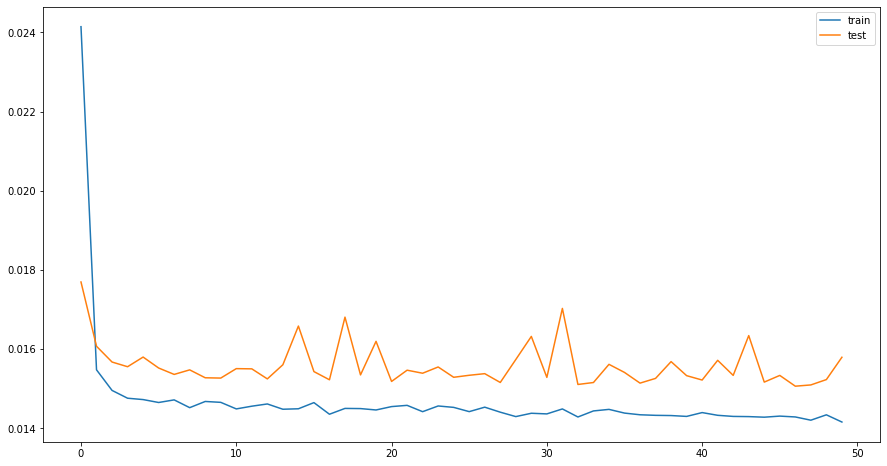

In [86]:
# plot history
fig = plt.figure(figsize=(15, 8))
pyplot.plot(cnn_lstm_history.history['loss'], label='train')
pyplot.plot(cnn_lstm_history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [99]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(trainY, cnn_lstm_train_pred)))
rmse = np.sqrt(mean_squared_error(testY, cnn_lstm_valid_pred))
print('Validation rmse:', rmse)

Train rmse: 0.022514142
Validation rmse: 0.031834472


In [88]:
# Actual prediction
ythat = model_cnn_lstm.predict(X_train_series_sub)
yhat = model_cnn_lstm.predict(X_valid_series_sub)

In [89]:
# We need to rescale the predictions because we applied normalization in the first place
## Rescale values
max_speed = train_data.max()
min_speed = train_data.min()

## actual train and test values
train_rescref = np.array(trainY * max_speed)
test_rescref = np.array(testY * max_speed)

In [90]:
## Rescale model predicted values
train_rescpred = np.array((ythat) * max_speed)
test_rescpred = np.array((yhat) * max_speed)

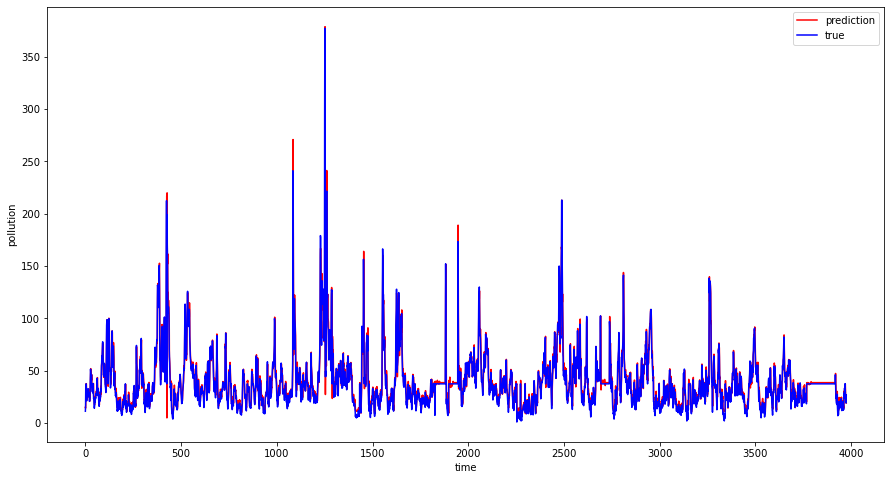

In [91]:
##all test result visualization
fig1 = plt.figure(figsize=(15, 8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = test_rescpred[:]
a_true = test_rescref[:]
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("time")
plt.ylabel("pollution")
plt.legend(loc="best", fontsize=10)
plt.show()

In [100]:
# Output all results to a sub-directory
import datetime
import pathlib
import os
path = pathlib.Path().absolute()
time = datetime.datetime.now().strftime("%m-%d-%Y %H-%M-%S")
result_dir = os.path.join (path, "experiments", time)
os.mkdir (result_dir)

# Create the result txt file
f = open(result_dir + "/" + "summary.txt", "w")

# Write experiment parameters
f.write ("---------Experiment Parameters--------")
f.write ("\nTrain-Test split rate: " + str(train_rate))
f.write ("\nNumber of epochs: " + str(n_epochs))
f.write ("\nBatch size: " + str(batch_size))
f.write ("\nShuffle during training: " + str(shuffle))
f.write ("\nVerbose: " + str(verbose))
f.write ("\n---------------------------")

# Write dataset details
f.write ("\n---------Dataset Details--------")
time_len= dfPollutant.shape[0]
f.write ("\nNo of timesteps:" + str(time_len))
f.write ("\nTrain data: " + str(train_data.shape))
f.write ("\nTest data: " + str(test_data.shape))

f.write ("\nTrain data X: " + str(trainX.shape))
f.write ("\nTrain data Y: " + str(trainY.shape))
f.write ("\nTest data X: " + str(testX.shape))
f.write ("\nTest data Y: " + str(testY.shape))
f.write ("\n---------------------------")

# Write model details
f.write ("\n---------Model Details--------")
f.write ("\nLSTM layer sizes: " + str(lstm_layer_sizes))
f.write ("\nLSTM activation functions: " + str(lstm_activations))
f.write ("\nCNN activation functions: " + str(cnn_activations))
f.write ("\nOptimizer: " + optimizer)
f.write ("\nLoss function: " + loss)
f.write ("\n---------------------------")

# Write results
f.write ('\nTest RMSE: %.3f' % rmse)

# Write visual outputs
fig.savefig (result_dir + "/" + "MAE-vs-Naive.png")
fig1.savefig (result_dir + "/" + "prediction-accuracy.png")

f.close ()